In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Select the dataset
dataset_name = "emnist/balanced"
# Load it into train_dataset and test_dataset with additional info in dataset_info
# the indicated split is 80% goes into training data and 20% for testing
# as_supervised=True is used to also load the labels which is needed for classification
(train_dataset, valid_dataset, test_dataset), dataset_info = tfds.load(
    dataset_name,
    split=["train[:90%]", "train[90%:]", "test"],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteI6T77L/emnist-train.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteI6T77L/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.0.0. Subsequent calls will reuse this data.


In [2]:
# Display data about the data
print(f"Dataset Name: {dataset_name}")
print(f"Number of Classes: {dataset_info.features['label'].num_classes}")
print(f"Class Names: {dataset_info.features['label'].names}")
print(f"Total Samples: {dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples}")
print(f"Number of Training Samples: {dataset_info.splits['train[:90%]'].num_examples}")
print(f"Number of Validation Samples: {dataset_info.splits['train[90%:]'].num_examples}")
print(f"Number of Test Samples: {dataset_info.splits['test'].num_examples}")

Dataset Name: emnist/balanced
Number of Classes: 47
Class Names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']
Total Samples: 131600
Number of Training Samples: 101520
Number of Validation Samples: 11280
Number of Test Samples: 18800


In [3]:
# A function to split the label from the images into X_valid/train and y_valid/train
def dataset_to_numpy(dataset):
   X = []
   y = []
   for features_labels in dataset:
       X.append(features_labels[0]/255)
       y.append(features_labels[1])
   X = np.array(X)
   y = np.array(y)
   X = X.reshape(X.shape[:-1])  # Remove the last dimension, which is indicated the color channel, in our case 1 for grayscale
   return X, y

In [4]:
# Split the datasets
train_dataset = tfds.as_numpy(train_dataset)
X_train, y_train = dataset_to_numpy(train_dataset)

valid_dataset = tfds.as_numpy(valid_dataset)
X_valid, y_valid = dataset_to_numpy(valid_dataset)

test_dataset = tfds.as_numpy(test_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Get the shapes
print("Shapes:")
print(f"Training: X: {X_train.shape} Y: {y_train.shape}")
print(f"Validation: X: {X_valid.shape} Y: {y_valid.shape}")
print(f"Test: X: {X_test.shape} Y: {y_test.shape}")


Shapes:
Training: X: (101520, 28, 28) Y: (101520,)
Validation: X: (11280, 28, 28) Y: (11280,)
Test: X: (18800, 28, 28) Y: (18800,)


In [47]:
number_of_classes='47'

model = keras.models.Sequential([
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

model.summary()


model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 5408)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               2769408   
                                                                 
 dense_20 (Dense)            (None, 128)               65664     
                                                                 
 dense_21 (Dense)            (None, 47)                6063      
                                                      

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=10,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=10,factor=0.2,min_lr=0.0001)

In [49]:
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
y_train_encoded = to_categorical(y_train, num_classes=47)
y_valid_encoded = to_categorical(y_valid, num_classes=47)
y_test_encoded = to_categorical(y_test, num_classes=47)

In [51]:
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_valid,y_valid_encoded), callbacks=[MCP,ES,RLP])

Epoch 1/10
3171/3173 [============================>.] - ETA: 0s - loss: 0.5252 - accuracy: 0.8222
Epoch 1: val_accuracy improved from -inf to 0.83688, saving model to Best_points.h5
3173/3173 [==============================] - 17s 5ms/step - loss: 0.5255 - accuracy: 0.8222 - val_loss: 0.4837 - val_accuracy: 0.8369 - lr: 0.0100
Epoch 2/10
  26/3173 [..............................] - ETA: 13s - loss: 0.4003 - accuracy: 0.8317

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3165/3173 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8547
Epoch 2: val_accuracy improved from 0.83688 to 0.84344, saving model to Best_points.h5
3173/3173 [==============================] - 14s 5ms/step - loss: 0.4067 - accuracy: 0.8548 - val_loss: 0.4399 - val_accuracy: 0.8434 - lr: 0.0100
Epoch 3/10
3161/3173 [============================>.] - ETA: 0s - loss: 0.3400 - accuracy: 0.8734
Epoch 3: val_accuracy improved from 0.84344 to 0.85355, saving model to Best_points.h5
3173/3173 [==============================] - 14s 4ms/step - loss: 0.3401 - accuracy: 0.8734 - val_loss: 0.4226 - val_accuracy: 0.8535 - lr: 0.0100
Epoch 4/10
3167/3173 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8875
Epoch 4: val_accuracy did not improve from 0.85355
3173/3173 [==============================] - 14s 5ms/step - loss: 0.2930 - accuracy: 0.8874 - val_loss: 0.4386 - val_accuracy: 0.8489 - lr: 0.0100
Epoch 5/10
3169/3173 [============================>

Text(0, 0.5, 'Accuray')

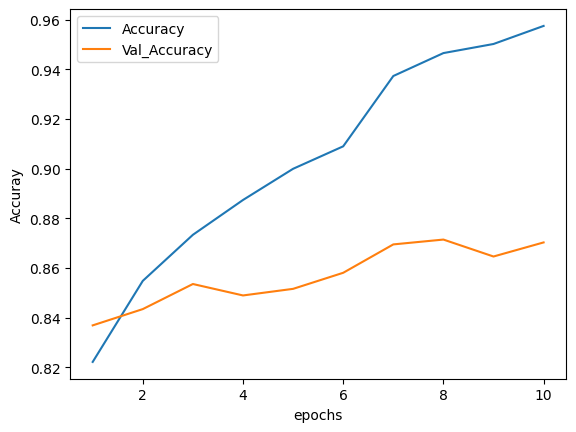

In [52]:
import seaborn as sns
q = len(history.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')

In [53]:
model.evaluate(X_test, y_test_encoded)

588/588 [==============================] - 2s 3ms/step - loss: 0.4897 - accuracy: 0.8655


[0.48974350094795227, 0.8655319213867188]